In [1]:
# ! pip install dask leidenalg xgboost  composition_stats igraph colorcet dask
# ! pip install tysserand libpysal geopandas scipy napari
# ! pip install opencv-python
# ! pip install "dask[distributed]"

In [2]:
import sys

path_src = '../src'
sys.path.append(path_src)
import importlib
import SpatialAnalysis as SpAn
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
import os
path_src = '../../mosna_benchmark/mosna/'
sys.path.append(path_src)
import mosna2 as mosna


Script loaded!
imported


/home/abdelmounim.essabbar/Projects/Spatial-Omics-Networks-Benchmark-/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 14:48:56.732848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 14:48:56.747291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 14:48:56.763466: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has

Script loaded!


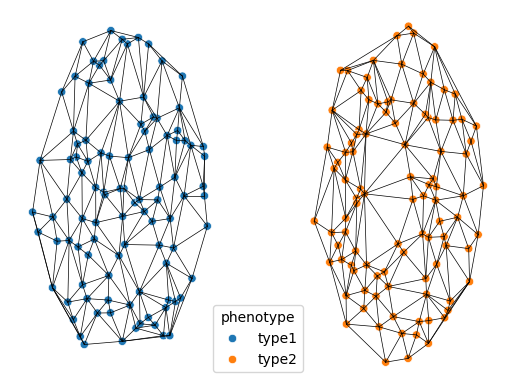

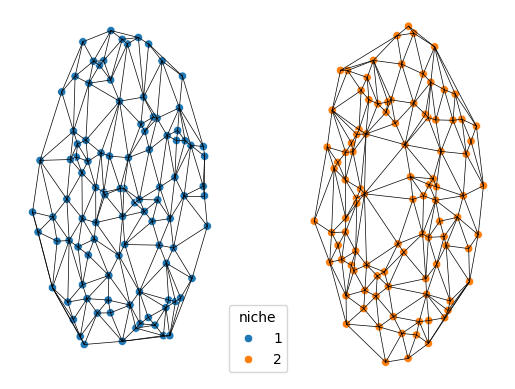

,x,y,phenotype,niche,type1,type2,patient,1,2
174,24.977837,8.60328,type2,2,0,1,1,0,1


In [3]:
thr = 5
importlib.reload(SpAn)
coords = pd.read_csv('../data/niche_simulations/isolated.csv',sep=',',index_col=0)
points = coords[['x','y']]
types = coords['phenotype']
edges = SpAn.delaunay_edges(points)
edges = SpAn.trim_edges_by_distance(points, edges, thr )
SpAn.plot_network(points, edges, types = types, linewidth = .5)


coords['niche'] = coords['phenotype'].str[-1:]
SpAn.plot_network(points, edges, types = coords['niche'], linewidth = .5)
dum = pd.get_dummies(coords['phenotype']).astype('int')
nodes = pd.concat([coords, dum],axis=1)
nodes['patient'] = '1'

dum_niches = pd.get_dummies(nodes['niche']).astype('int')
dum_niches.sample()
NichDum = pd.get_dummies(nodes['niche']).astype('int')
niche_cols = NichDum.columns
nodes = pd.concat( [nodes,NichDum] , axis=1)

out_path = '../data/simulation_coordiantes/mosna/isolated_niches/net_dir/'
out_dir = out_path + 'nodes_patient-patient.csv'
os.makedirs(out_path, exist_ok=True)
nodes.to_csv(out_dir, index=False)

nodes.sample()

# Mosna

In [17]:
pd.DataFrame(edges).to_csv(out_path + 'edges_patient-patient.csv', index=False)

imported
Loading clusterer object and cluster labels
There are 2 clusters


<Figure size 3000x3000 with 0 Axes>

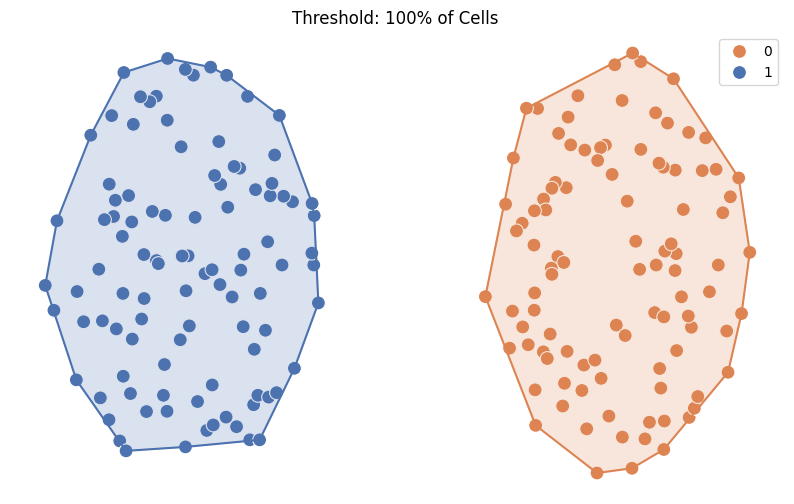

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [22]:
attributes_col = nodes.columns
marker_col = dum.columns

data_info = ['patient']
importlib.reload(mosna)
var_aggreg = mosna.compute_spatial_omic_features_single_network(
    method = 'NAS',
    net_dir = out_path,  
    data_info = data_info,
    extension = 'csv',
    read_fct = pd.read_csv,
    attributes_col=attributes_col, 
    use_attributes=marker_col, # use all attributes 
    make_onehot=False, 
    stat_funcs = 'default', 
    stat_names = 'default', 
    id_level_1='patient',
    save_intermediate_results=False, 
    dir_save_interm=None,
    add_sample_info = False,
    verbose=1,
    )

plt.gcf().set_size_inches(30, 30)

cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 30, 
    'metric': 'euclidean', #'manhattan', # or 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 30, 
    'resolution_parameter': 0.005,
}

sof_dir = out_path

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, sof_dir, **cluster_params)

import pathlib
sof_dir = pathlib.Path(sof_dir)

var = 'MOSNA'

nodes[var] = cluster_labels

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.2)


# UTAG

In [27]:
from utag import utag
import scanpy as sc
import squidpy as sq
import anndata
import numpy as np
import matplotlib.pyplot as plt
from anndata import AnnData
import anndata as ad

X = pd.get_dummies(coords['phenotype']).astype(np.float64)

obs = coords[['x', 'y']]
obs['roi'] = 'ROI1'
# Create 'var' dataframe with the one-hot encoded types columns
var = pd.DataFrame(index=X.columns)

# Create AnnData object
minimal_adata = ad.AnnData(X=X.values, obs=obs, var=var)
minimal_adata.obsm['spatial'] = coords[['x', 'y']].values

single_slide = minimal_adata.copy()
display(single_slide)
# Run UTAG on provided data
utag_single_results = utag(
    single_slide,
    slide_key="roi",
    max_dist=5,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [1.5,1,.5,.3,.2,.1,.05,.01,.005]
)

var= 'UTAG'
nodes[var] = utag_single_results.obs['UTAG Label_leiden_0.1'].values

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.2)


ModuleNotFoundError: No module named 'UTAG'

# Cellcharter

In [7]:
import anndata as ad
import cellcharter as cc
nodes.sample()

,x,y,phenotype,niche,type1,type2,patient,1,2,MOSNA,UTAG
131,23.880516,12.672639,type2,2,0,1,1,0,1,0,1


/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


  0%|          | 0/4 [00:00<?, ?it/s]

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

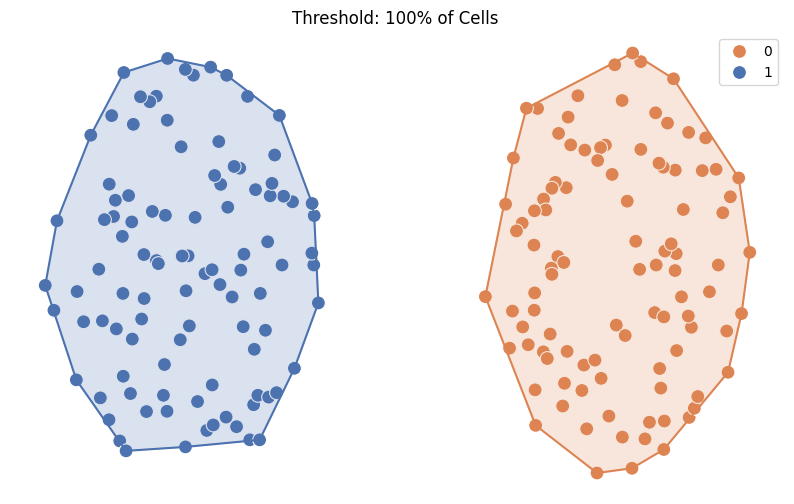

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [8]:
adata = ad.AnnData(X=dum)
adata.obs['niche'] = nodes['niche'].values
adata.obs['cell_type'] = nodes['phenotype'].values
adata.obs['patient'] = nodes['patient'].values
adata.uns['spatial'] = {'coordinates': nodes[['x', 'y']].values.tolist()}
adata.obsm['spatial'] = nodes[['x', 'y']].values
adata

sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True)

cc.gr.remove_long_links(adata)

cc.gr.aggregate_neighbors(adata, n_layers=3)
gmm = cc.tl.Cluster(
    n_clusters=2, 
    trainer_params=dict(accelerator='gpu', devices=1)
)
gmm.fit(adata, use_rep='X_cellcharter')
adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')


var = 'CellCharter'

nodes[var] = adata.obs['spatial_cluster'].values

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=1, alpha=0.2)

# Stagate

# BayesSpace

#### Check file ```rscript/BayesSpace.R``` for details about running BayesSpace 

In [9]:
nodes.shape

(200, 12)

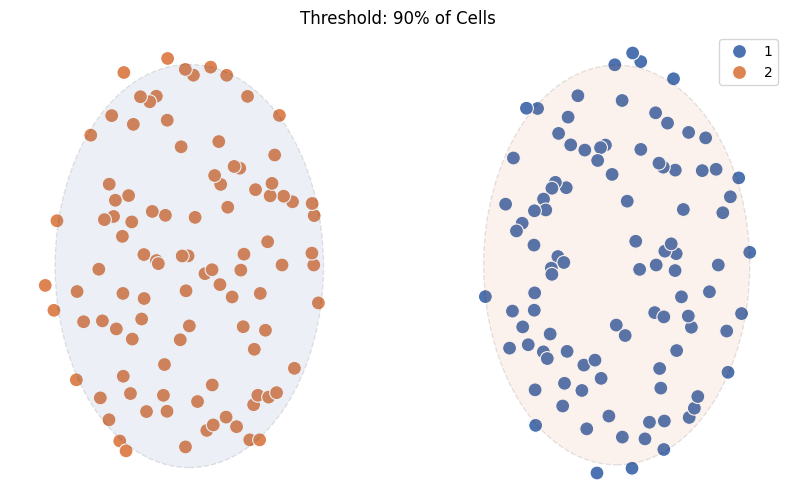

<Axes: title={'center': 'Threshold: 90% of Cells'}>

In [10]:
BayesSpace = pd.read_csv('../data/simulation_coordiantes/BayesSpace/isolated_niches.csv', index_col=0)
var = 'BayesSpace'
nodes[var] = BayesSpace['spatial.cluster'].values
SpAn.plot_cells_with_circles(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)


In [21]:
! pip install squidpy scanpy anndata

  Using cached squidpy-1.6.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached dask_image-2024.5.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached docrep-0.3.2-py3-none-any.whl
  Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl.metadata (13 kB)
  Using cached omnipath-1.0.8-py3-none-any.whl.metadata (6.5 kB)
  Using cached spatialdata-0.2.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached validators-0.33.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached xarray-2024.7.0-py3-none-any.whl.metadata (11 kB)
  Using cached zarr-2.18.2-py3-none-any.whl.metadata (5.7 kB)
  Using cached aiohappyeyeballs-2.3.4-py3-none-any.whl.metadata (5.6 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached pims-0.7.tar.gz (87 kB)
  Preparing metadata (setup.py) ... done
  Using cached inflect-7.3.1-py3-none-any.whl.metadata (21 kB)
  Using cached fsspec-2023.6.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached multiscale_spatial_image-1.0.1-py3-none-any.whl.met

In [22]:
import squidpy as sq
import scanpy as sc
import anndata as ad
import numpy as np

# Assuming `data` is your dataset containing 'coordinates' and 'cell_type'
# Create an AnnData object

adata = ad.AnnData(X=dum)  # Random data, replace with your actual gene expression matrix

adata.obs['cell_type'] = pd.Categorical(nodes['phenotype'])  # Random cell types, replace with actual
adata.obsm['spatial'] = nodes[['x','y']].values  # Random coordinates, replace with actual
adata

AnnData object with n_obs × n_vars = 200 × 2
    obs: 'cell_type'
    obsm: 'spatial'

# SquidPy + scanpy

/home/abdelmounim.essabbar/Projects/Spatial-Omics-Networks-Benchmark-/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 1000/1000 [00:00<00:00, 3924.48/s]
/home/abdelmounim.essabbar/Projects/Spatial-Omics-Networks-Benchmark-/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


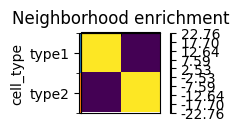

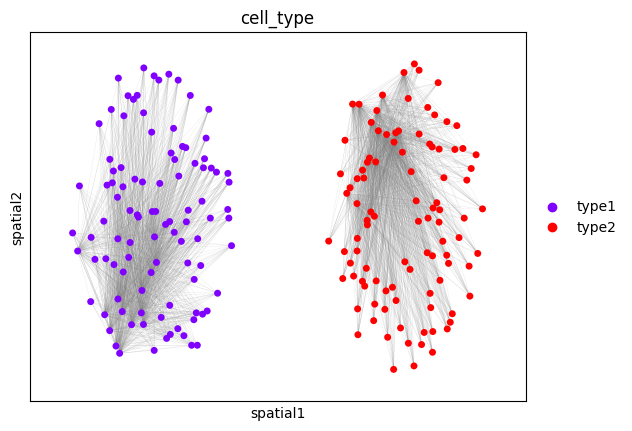

/home/abdelmounim.essabbar/Projects/Spatial-Omics-Networks-Benchmark-/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


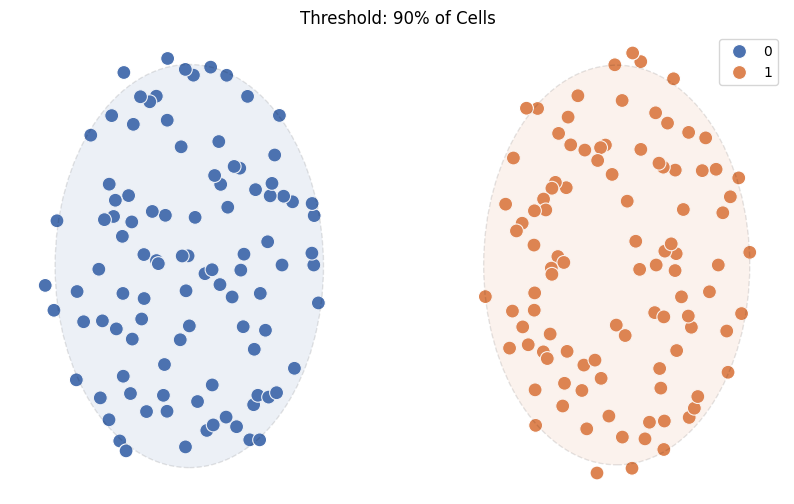

<Axes: title={'center': 'Threshold: 90% of Cells'}>

In [23]:
import squidpy as sq
import scanpy as sc
import anndata as ad
import numpy as np

# Assuming `data` is your dataset containing 'coordinates' and 'cell_type'
# Create an AnnData object

adata = ad.AnnData(X=dum)  # Random data, replace with your actual gene expression matrix

adata.obs['cell_type'] = pd.Categorical(nodes['phenotype'])  # Random cell types, replace with actual
adata.obsm['spatial'] = nodes[['x','y']].values  # Random coordinates, replace with actual

# Calculate neighborhood enrichment
sq.gr.spatial_neighbors(adata, coord_type="generic")  # Adjust parameters as needed
sq.gr.nhood_enrichment(adata, cluster_key='cell_type')

# Plot neighborhood enrichment
sq.pl.nhood_enrichment(adata, cluster_key='cell_type')

sq.gr.spatial_neighbors(adata, coord_type='generic', delaunay=True)
sc.pp.neighbors(adata)

# Additional visualization to explore the spatial distribution
sc.pl.embedding(adata, basis='spatial', color='cell_type', edges=True, edges_width=0.05, s=100, palette='rainbow')


sc.pp.neighbors(adata, 5)
# Perform clustering
sc.tl.leiden(adata,  resolution=1.2)

# Add clustering results to the data
adata.obs['clusters'] = adata.obs['leiden']

spatial_connectivities = adata.obsp["spatial_connectivities"]
edges_matrix = pd.DataFrame(spatial_connectivities.toarray(), 
                                         index=adata.obs_names, 
                                         columns=adata.obs_names)


var = 'SquidPy'
nodes[var] =  adata.obs['leiden'].values
SpAn.plot_cells_with_circles(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# StLearn

In [12]:
coordinates = nodes[['x','y']]

/home/abdelmounim.essabbar/mambaforge/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


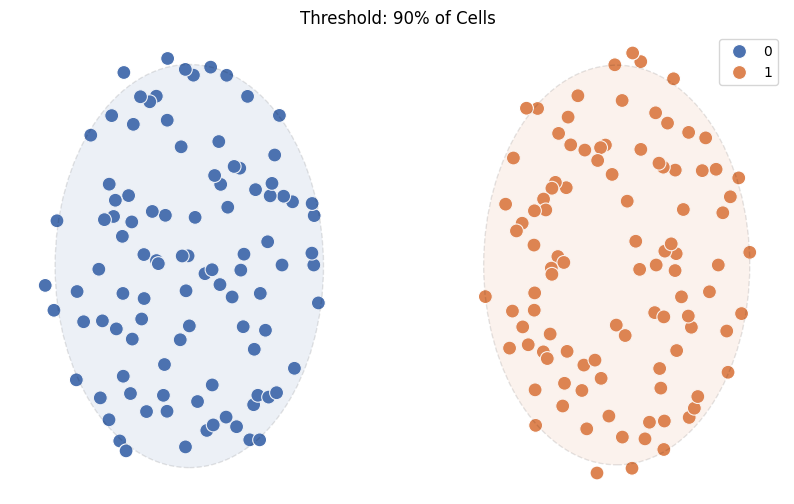

<Axes: title={'center': 'Threshold: 90% of Cells'}>

In [13]:
import stlearn as st
import scanpy as sc

# Create an AnnData object
adata = sc.AnnData(X = dum )
adata.obsm['spatial'] = coordinates.values

# Add cell types as metadata
adata.obs['cell_type'] = pd.Categorical(nodes['phenotype'].values)

# Normalize and scale the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# adata = adata[:, adata.var.highly_variable]

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbors and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# Visualize the clusters
# sc.pl.umap(adata, color=['leiden', 'cell_type'])


var = 'StLearn'
nodes[var] =  adata.obs['leiden'].values
SpAn.plot_cells_with_circles(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)

# imcRtools

#### Check file ```rscript/imcRtools.R``` for more details 

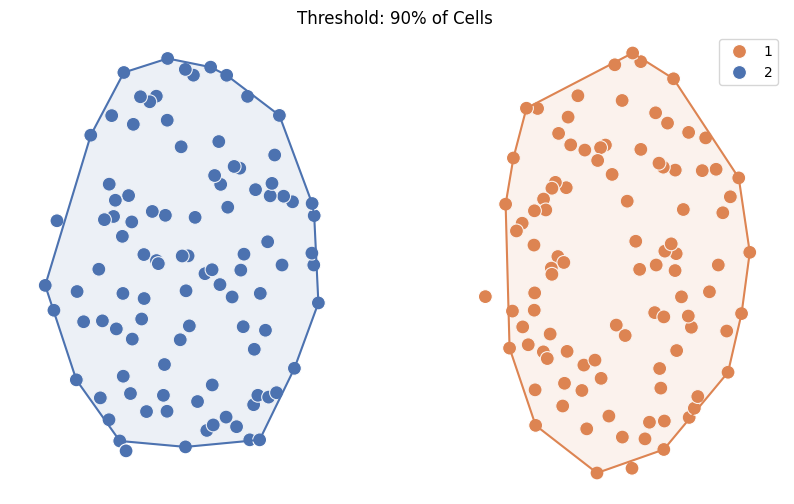

<Axes: title={'center': 'Threshold: 90% of Cells '}>

In [14]:
aN = pd.read_csv('../data/simulation_coordiantes/imcRtools/isolated_niches.csv')
imcRtoolsAN = pd.concat([nodes,aN], axis=1)
imcRtoolsAN.sample()


var = 'imcRtools'
nodes[var] = imcRtoolsAN['clustered_neighbors'].values
SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes[var], quantile_threshold=.9, alpha=0.1)

# Compare

# Adding an annotation of each cell type an it neighboor

In [15]:
nodes
Edges = pd.DataFrame(edges)
Neighborhood = []

def get_type(nodes, node_idx, type = 'niche'):
    df = nodes.iloc[node_idx,:]
    return df[type]

for node in nodes.index:
    source = node
    node_source = nodes.iloc[source,:]
    targets = Edges.loc[Edges[0] == node , 1].to_list()
    sources = Edges.loc[Edges[1] == node , 0].to_list()
    if len(sources)>0:
        targets+= sources
    type_source = get_type( nodes, source, 'niche')
    associated_types = set()
    for target in targets:
        associated_types.add(get_type( nodes, target, 'niche'))
    associated_types = '_'.join(sorted(associated_types))
    Neighborhood.append(associated_types)

nodes['Neighborhood'] = Neighborhood

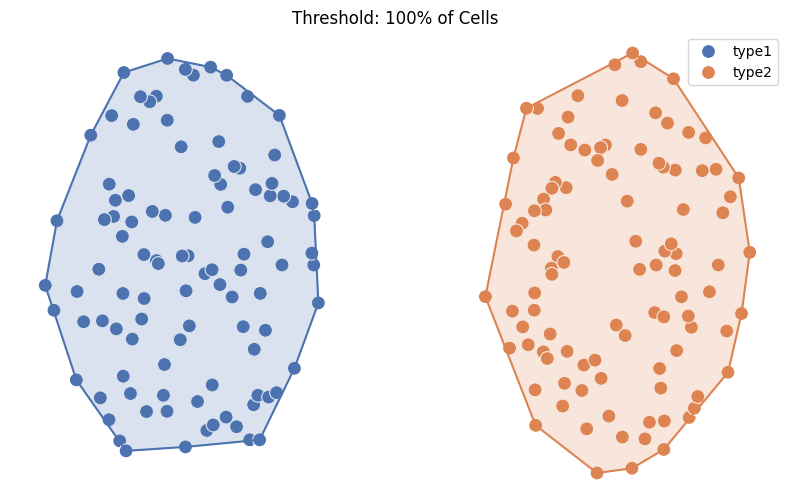

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [16]:
SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes['phenotype'], quantile_threshold=1, alpha=0.2)


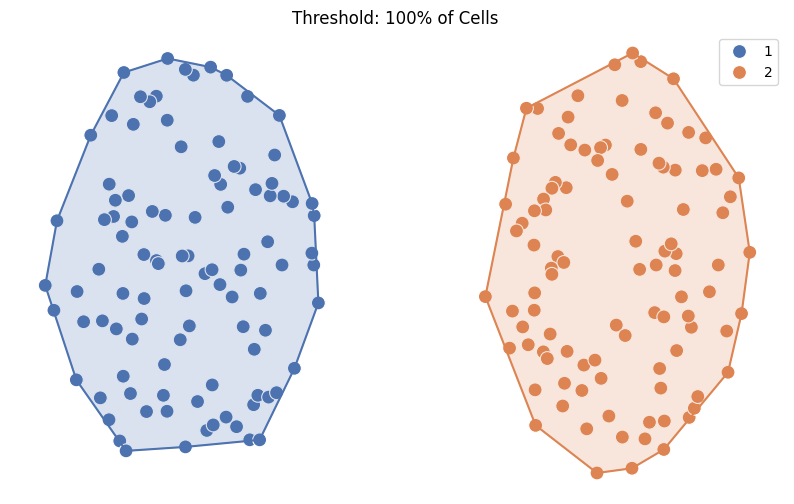

<Axes: title={'center': 'Threshold: 100% of Cells '}>

In [17]:

SpAn.plot_cells_with_hulls(nodes[['x','y']], nodes['Neighborhood'], quantile_threshold=1, alpha=0.2)


In [18]:
Nodes = nodes.copy()
Nodes = Nodes.drop(['x', 'y', 'niche', 'phenotype', 'type1', 'type2', 'patient'],axis=1)
Nodes.sample()

,1,2,MOSNA,UTAG,CellCharter,BayesSpace,SquidPy,StLearn,imcRtools,Neighborhood
60,1,0,1,0,1,2,0,0,2,1


Comparing 2 and Neighborhood


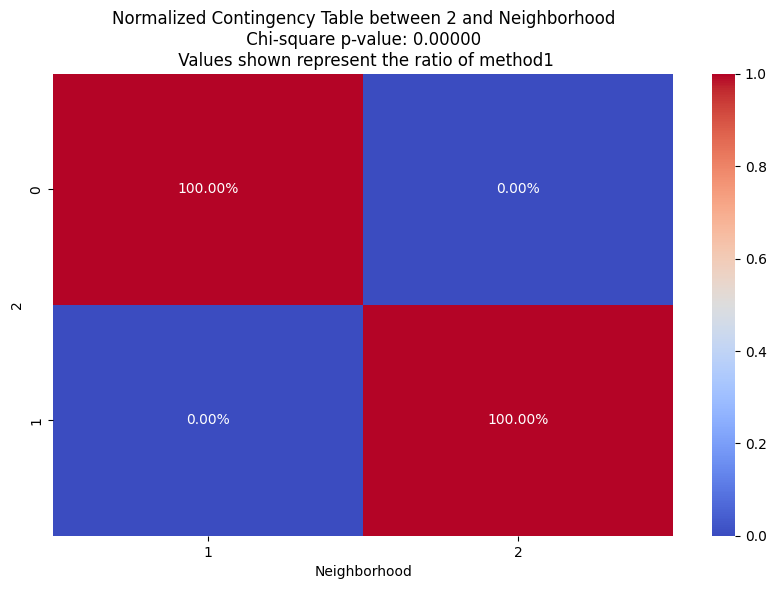

Comparing MOSNA and Neighborhood


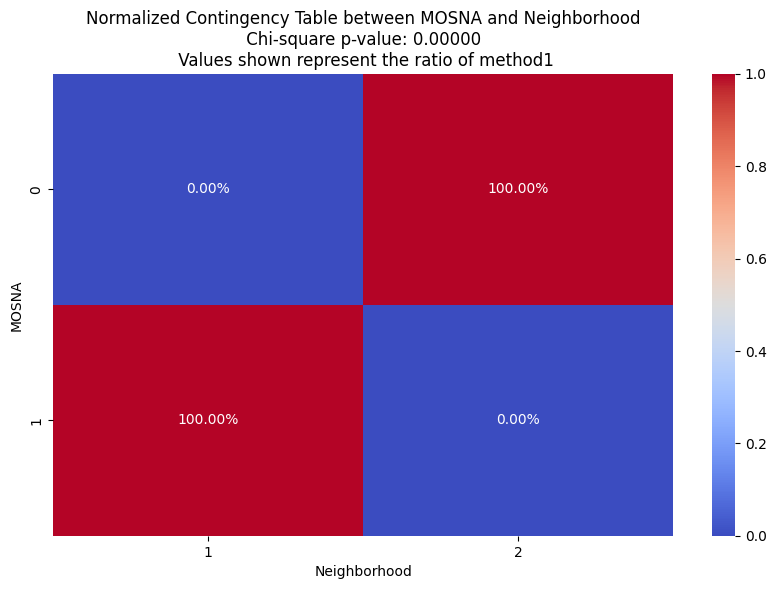

Comparing UTAG and Neighborhood


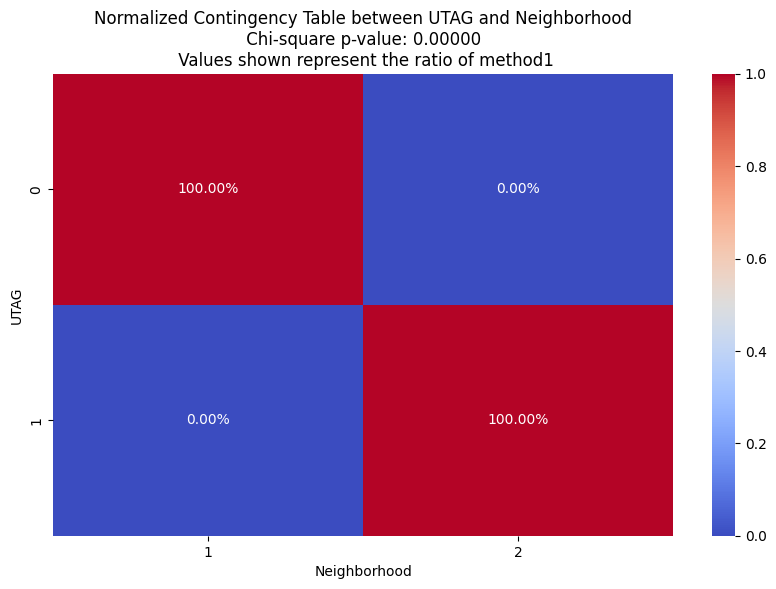

Comparing CellCharter and Neighborhood


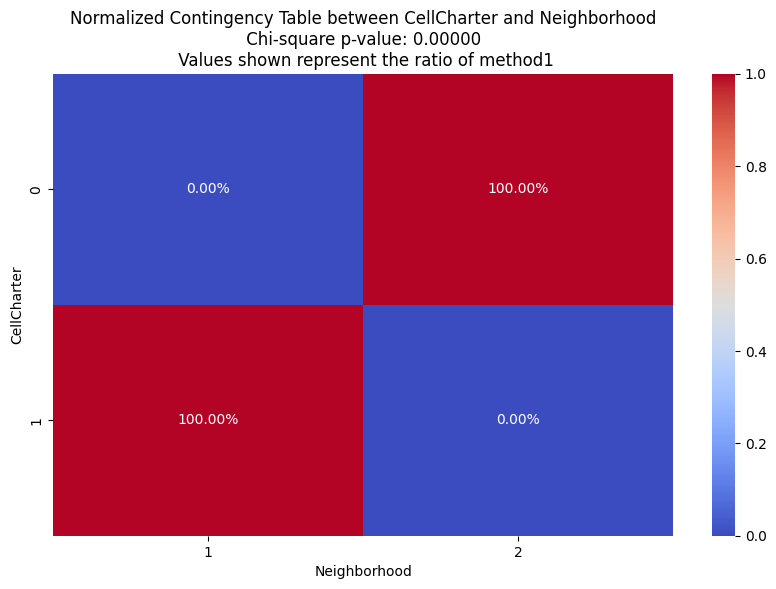

Comparing BayesSpace and Neighborhood


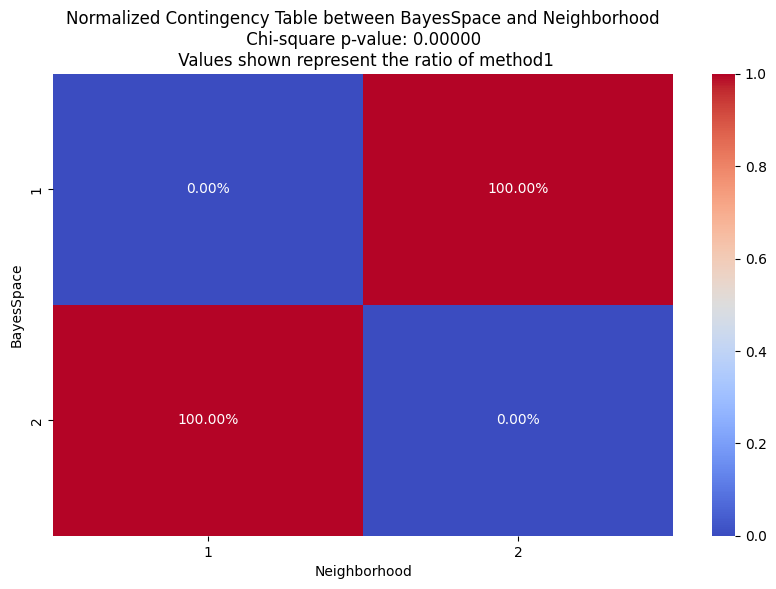

Comparing SquidPy and Neighborhood


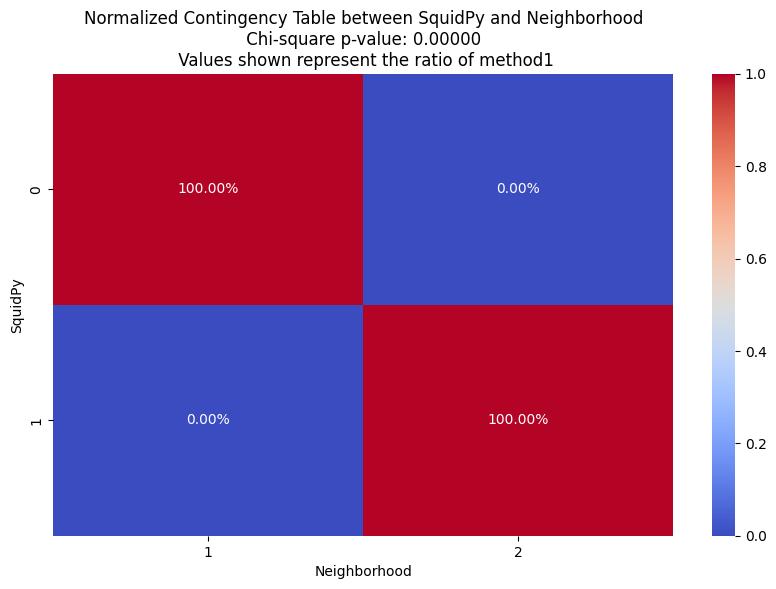

Comparing StLearn and Neighborhood


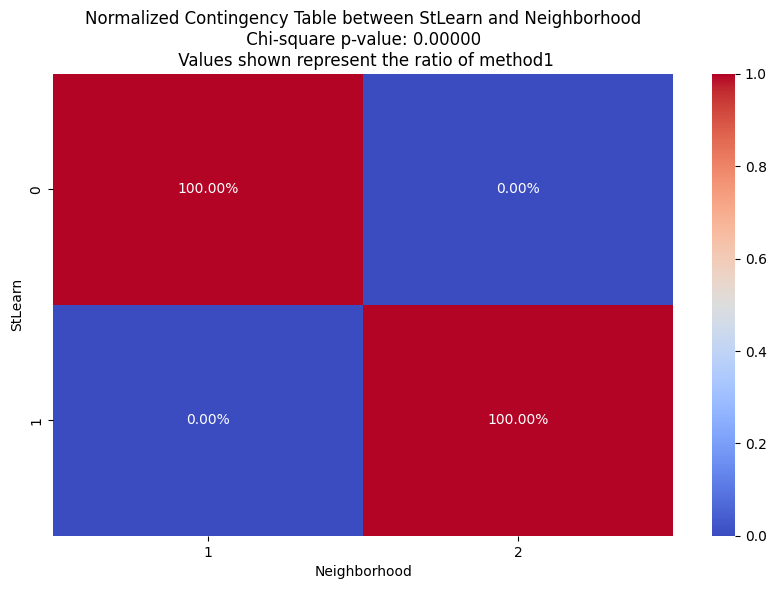

Comparing imcRtools and Neighborhood


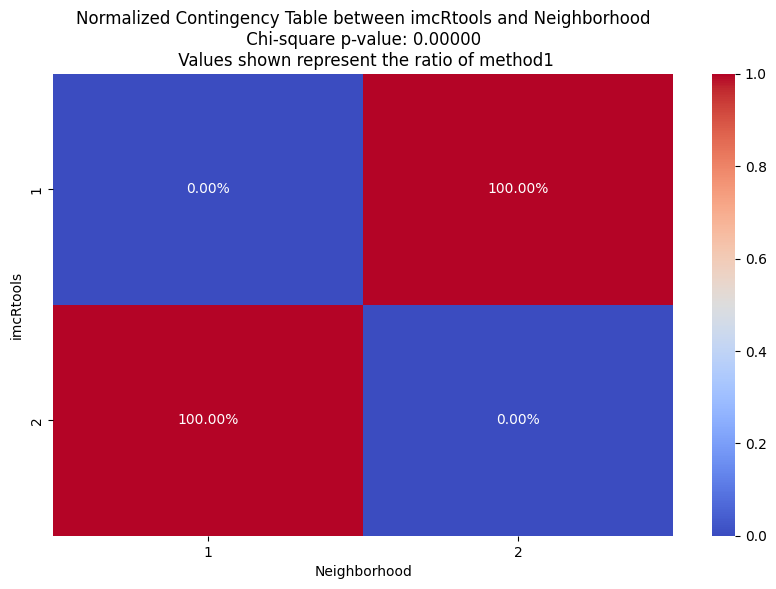

Comparing Neighborhood and Neighborhood


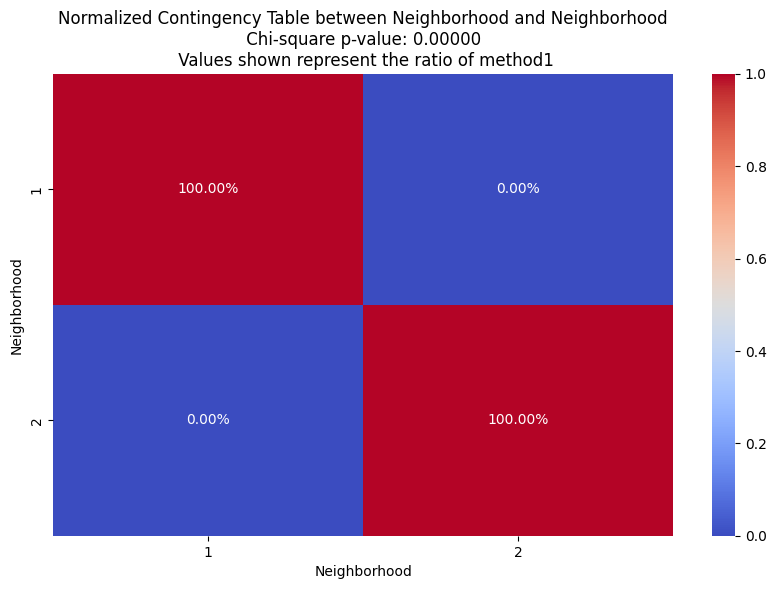

{'2': 1.0,
 'MOSNA': 1.0,
 'UTAG': 1.0,
 'CellCharter': 1.0,
 'BayesSpace': 1.0,
 'SquidPy': 1.0,
 'StLearn': 1.0,
 'imcRtools': 1.0,
 'Neighborhood': 1.0}

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Create a DataFrame
df = pd.DataFrame(Nodes).iloc[:,1:]


# Function to create and plot a normalized contingency table
def plot_normalized_contingency_table(df, method1, method2):
    contingency_table = pd.crosstab(df[method1], df[method2])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    
    # Normalize the contingency table
    normalized_contingency_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(normalized_contingency_table, annot=True, cmap='coolwarm', fmt='.2%')
    plt.title(f'Normalized Contingency Table between {method1} and {method2}\n Chi-square p-value: {p:.5f} \n Values shown represent the ratio of method1')
    plt.show()
    
    return normalized_contingency_table

# Compare each pair of methods
methods = df.columns
mean_acc = {}
for i in range(len(methods)):
    method1 = methods[i]
    method2 = 'Neighborhood'
    print(f'Comparing {method1} and {method2}')
    contingency_table = plot_normalized_contingency_table(df, method1, method2)
    mean_acc[method1] = contingency_table.max(axis=0).mean()

mean_acc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


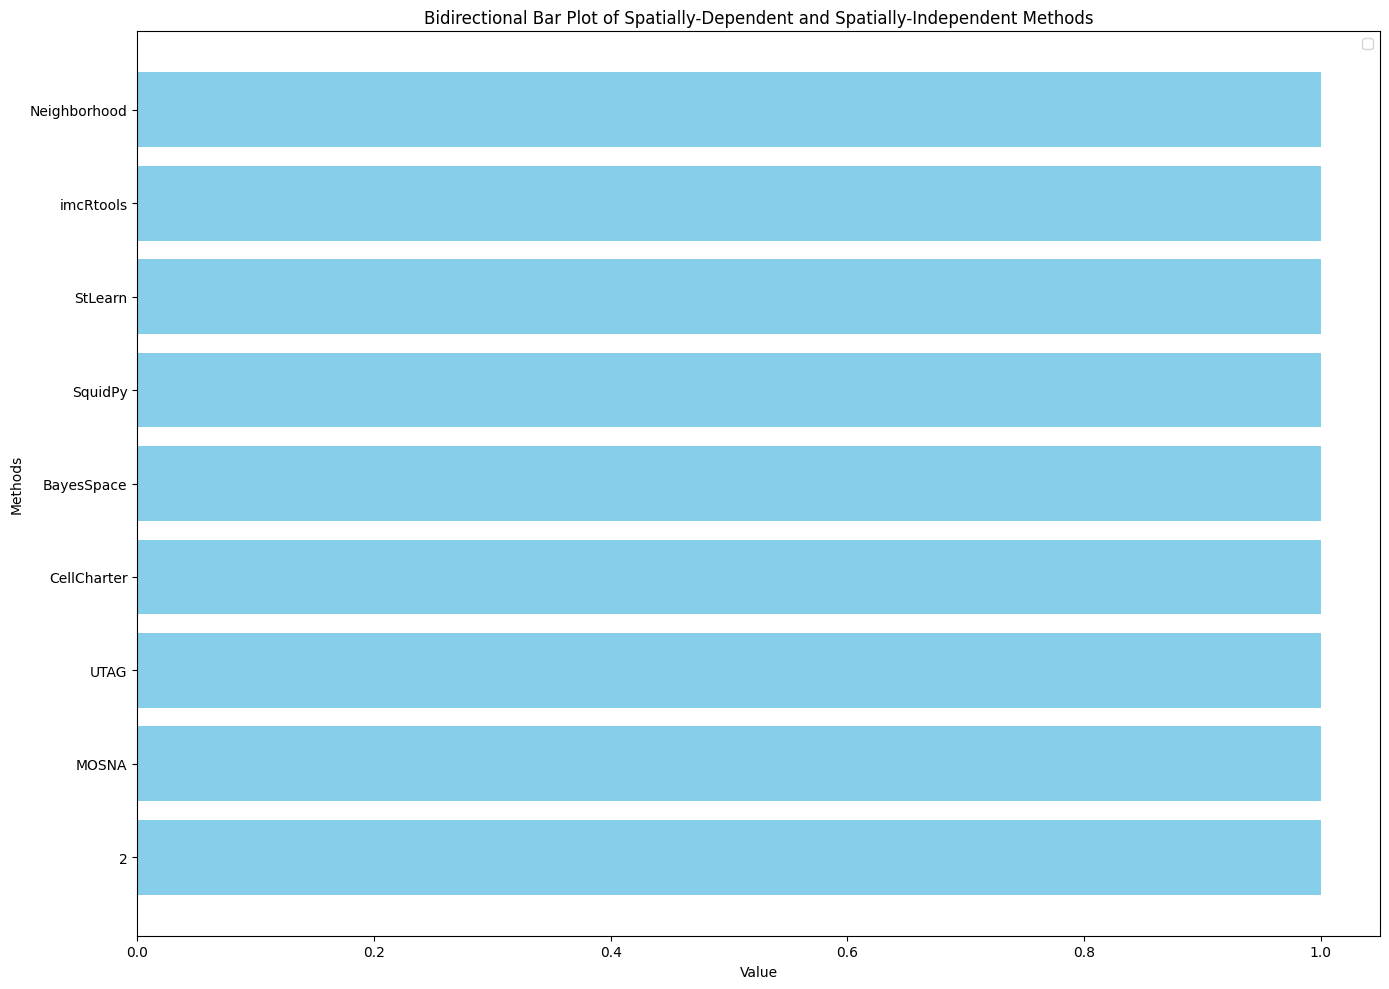

In [20]:

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(mean_acc.items()), columns=['Method', 'Value'])

# Separate the data into two categories: Dependent and Independent
df_iso = df

# Create the bidirectional bar plot
fig, ax = plt.subplots(figsize=(14, 10))

ax.barh(df_iso['Method'], df_iso['Value'], color='skyblue')

ax.set_xlabel('Value')
ax.set_ylabel('Methods')
ax.set_title('Bidirectional Bar Plot of Spatially-Dependent and Spatially-Independent Methods')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [24]:
type = 'isolated'

In [25]:
df_iso['model'] = type
df_iso.to_csv(f'../data/niche_simulations/nodes{type}.csv')

# ScanIT

<!-- ! pip install git+https://github.com/zcang/SCAN-IT.git@ebf38949eea9348cd1791f392789a8a8c0ae1e47#egg=scanit -->

In [22]:
# ! pip install gudhi networkx
# ! pip install torchvision 
# ! pip install torch torchvision torchaudio
! pip show torch
! pip install --upgrade torch

! pip cache purge
! pip install torch

! pip uninstall torch -y
! pip install torch



Files removed: 2
Found existing installation: torch 2.4.0
Uninstalling torch-2.4.0:
  Successfully uninstalled torch-2.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 8.4 MB/s eta 0:00:0000:0100:03m


In [24]:
import gc
import scanit
import torch
import random
import scanpy as sc
import pandas as pd
import anndata
import numpy as np
from scipy import sparse
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
import stlearn as st
from pathlib import Path


AttributeError: module 'torch' has no attribute 'Size'